In [1]:
import sys
import os
import cv2
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from datetime import datetime
from importlib import reload
from misc.utils import generate_generator, gen_imgPaths_and_labelPaths, monitor_mae, monitor_mse
from models import MobileNet

# Settings
dataset = "B"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
np.random.seed(31415)

Using TensorFlow backend.


In [2]:
# # GPU check

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

## Data preprocessing

In [3]:
# Setting up paths

train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels = gen_imgPaths_and_labelPaths(dataset)

/datasets/crowd/ShanghaiTech/original/part_B/test_data/images/


In [4]:
# # Data import
# train_generator = generate_generator(train_paths, train_labels, batch_size=len(train_paths))
# validation_generator = generate_generator(validation_paths, validation_labels, batch_size=len(validation_paths))
# test_generator = generate_generator(test_paths, test_labels, batch_size=len(test_paths))
# train_img, train_labels = train_generator.__next__()
# print('Train data reading is done.')
# validation_img, validation_labels = validation_generator.__next__()
# print('Validation data reading is done.')
# test_img, test_labels = test_generator.__next__()
# print('Test data reading is done.')

In [5]:
# # Save preprocessed data

# if not os.path.exists('./data_preprocessed'):
#     os.makedirs('./data_preprocessed')
# np.save('./data_preprocessed/train_img.npy', train_img)
# np.save('./data_preprocessed/train_labels.npy', train_labels)
# np.save('./data_preprocessed/validation_img.npy', validation_img)
# np.save('./data_preprocessed/validation_labels.npy', validation_labels)
# np.save('./data_preprocessed/test_img.npy', test_img)
# np.save('./data_preprocessed/test_labels.npy', test_labels)

In [6]:
# Read data into memory

train_img, train_labels, validation_img, validation_labels, test_img, test_labels = (
    np.load('./data_preprocessed/train_img.npy'),
    np.load('./data_preprocessed/train_labels.npy'),
    np.load('./data_preprocessed/validation_img.npy'),
    np.load('./data_preprocessed/validation_labels.npy'),
    np.load('./data_preprocessed/test_img.npy'),
    np.load('./data_preprocessed/test_labels.npy')
)

## MobileNet

In [7]:
# Remove previous tensorboard data

if os.path.exists('./logs/train/'):
    shutil.rmtree('./logs/train/')
    
if os.path.exists('./logs/validation/'):
    shutil.rmtree('./logs/validation/')

In [8]:
# Model definition

reload(MobileNet)

epochs = 10
batch_size = 20
model_name = 'mobilenet'
submodel_name = 'base'

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(log_dir='./logs')

model = MobileNet.MobileNet()

model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam,
              metrics=[monitor_mae, monitor_mse])

history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val,
               checkpointer_best_train, checkpointer_tensorboard]
)

Train on 3249 samples, validate on 351 samples
Epoch 1/10
3249/3249 [==============================] - 16s 5ms/step - loss: 0.0353 - monitor_mae: 4278.5454 - monitor_mse: 2160.7664 - val_loss: 4.1728e-04 - val_monitor_mae: 1124.8213 - val_monitor_mse: 24.9969

Epoch 00001: val_loss improved from inf to 0.00042, saving model to ./weights/mobilenet_base_B_val.hdf5

Epoch 00001: loss improved from inf to 0.03529, saving model to ./weights/mobilenet_base_B_train.hdf5
Epoch 2/10
3249/3249 [==============================] - 12s 4ms/step - loss: 0.0010 - monitor_mae: 1373.5092 - monitor_mse: 62.6466 - val_loss: 1.4258e-04 - val_monitor_mae: 173.5364 - val_monitor_mse: 8.5411

Epoch 00002: val_loss improved from 0.00042 to 0.00014, saving model to ./weights/mobilenet_base_B_val.hdf5

Epoch 00002: loss improved from 0.03529 to 0.00102, saving model to ./weights/mobilenet_base_B_train.hdf5
Epoch 3/10
3249/3249 [==============================] - 12s 4ms/step - loss: 8.3429e-04 - monitor_mae: 1215

2020-09-20_04:56:50_mobilenet_base


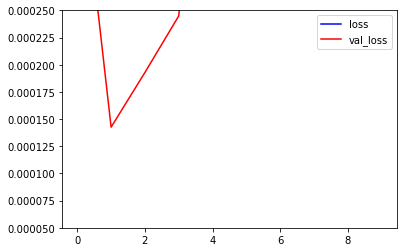

In [9]:
# Training history

val_loss, loss = history.history['val_loss'], history.history['loss']

plt.plot(loss, 'b')
plt.gca().set_ylim([0.00005, 0.00025])
plt.plot(val_loss, 'r')
plt.gca().set_ylim([0.00005, 0.00025])
plt.legend(['loss', 'val_loss'])

plt.savefig(os.path.join('results', f'{res_name}.png'))
pd.DataFrame({'loss': loss, 'val_loss': val_loss}).to_csv(
    os.path.join('results', f'{res_name}_train.csv'), index=False)

print(res_name)

In [10]:
# Model test

model = load_model(weights_val_path, custom_objects={
                   'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

ae = []
se = []
num_test = len(test_paths)
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)

mae = np.mean(ae)
rmse = np.sqrt(np.mean(se))

pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]}).to_csv(
    os.path.join('results', f'{res_name}_test.csv'), index=False)

print(res_name)
print(f'MAE: {mae}, RMSE: {rmse}')

2020-09-20_04:56:50_mobilenet_base
MAE: 191.44982465913023, RMSE: 213.53237518427656


In [11]:
# # Results presentation
# ae = []
# se = []
# num_test = 5
# for i in range(test_img.shape[0])[:num_test]:
#     inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
#     outputs = np.squeeze(model.predict(inputs))
#     density_map = np.squeeze(test_labels[i])
#     count_label = np.sum(density_map)
#     count_prediction = np.sum(outputs)
#     fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
#     plt.suptitle(' '.join([
#         'count_label:', str(round(count_label, 3)),
#         'count_prediction:', str(round(count_prediction, 3))
#     ]))
#     ax0.imshow(np.squeeze(inputs), cmap='gray')
#     ax1.imshow(density_map * (255 / (np.max(density_map) - np.min(density_map))), cmap='gray')
#     ax2.imshow(outputs * (255 / (np.max(outputs) - np.min(outputs))), cmap='gray')
#     plt.show()
#     ae.append(abs(count_label - count_prediction))
#     se.append((count_label - count_prediction) ** 2)
# mae = np.mean(ae)
# mse = np.mean(se)
# print('mae:', mae, 'mse:', mse)